# Logistic map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import sympy as sp
#%matplotlib inline
#%config InlineBackend.figure_formats={'retina','png'}
%matplotlib nbagg

## Map and analitic treatment

Defining the map instelf $x_{n+1}=r x_n(1-x_n)$, and its iterates

The functions in this notebook are optimized for speed -- lokk ate the notebook [LogisticMap_speedup.ipynb](LogisticMap_speedup.ipynb) for the discussion, if you are interested in writing fast Python code.

In [2]:
@jit
def lmap(x, r):
    """Returns the Logistic map"""
    return r*x*(1-x)

@jit
def lmap_n(x, r, n):
    """Returns the n-th iterate of the Logistic map"""
    for i in range(n):
        x = lmap(x,r)
    return x

In [3]:
@jit
def get_cycle(r, x0=0.25, npoints=1000):
    """Get NPOINTS of the Logistic map cycle starting from X0"""
    x = x0
    cycles = np.empty(npoints)
    cycles[0] = x
    for i in range(npoints-1):
        x = lmap(x,r)
        cycles[i+1] = x
    return cycles

In [4]:
def plot_iterates(r, nl, figsize=(6,6), points=1000):
    """Plots several iterate maps of the orders given in the list NL"""
    plt.figure(figsize=figsize)
    plt.plot([0,1], [0,1]) # Plot the reference line
    plt.title("$r=%g$"%(r))
    xran = np.linspace(0, 1, num=points)
    for n in nl:
        plt.plot(xran, lmap_n(xran, r, n), label='$f^{(%d)}$'%(n))
    plt.legend()

The typical map. We can see two FP for the map intersecting the $x$ line

<IPython.core.display.Javascript object>


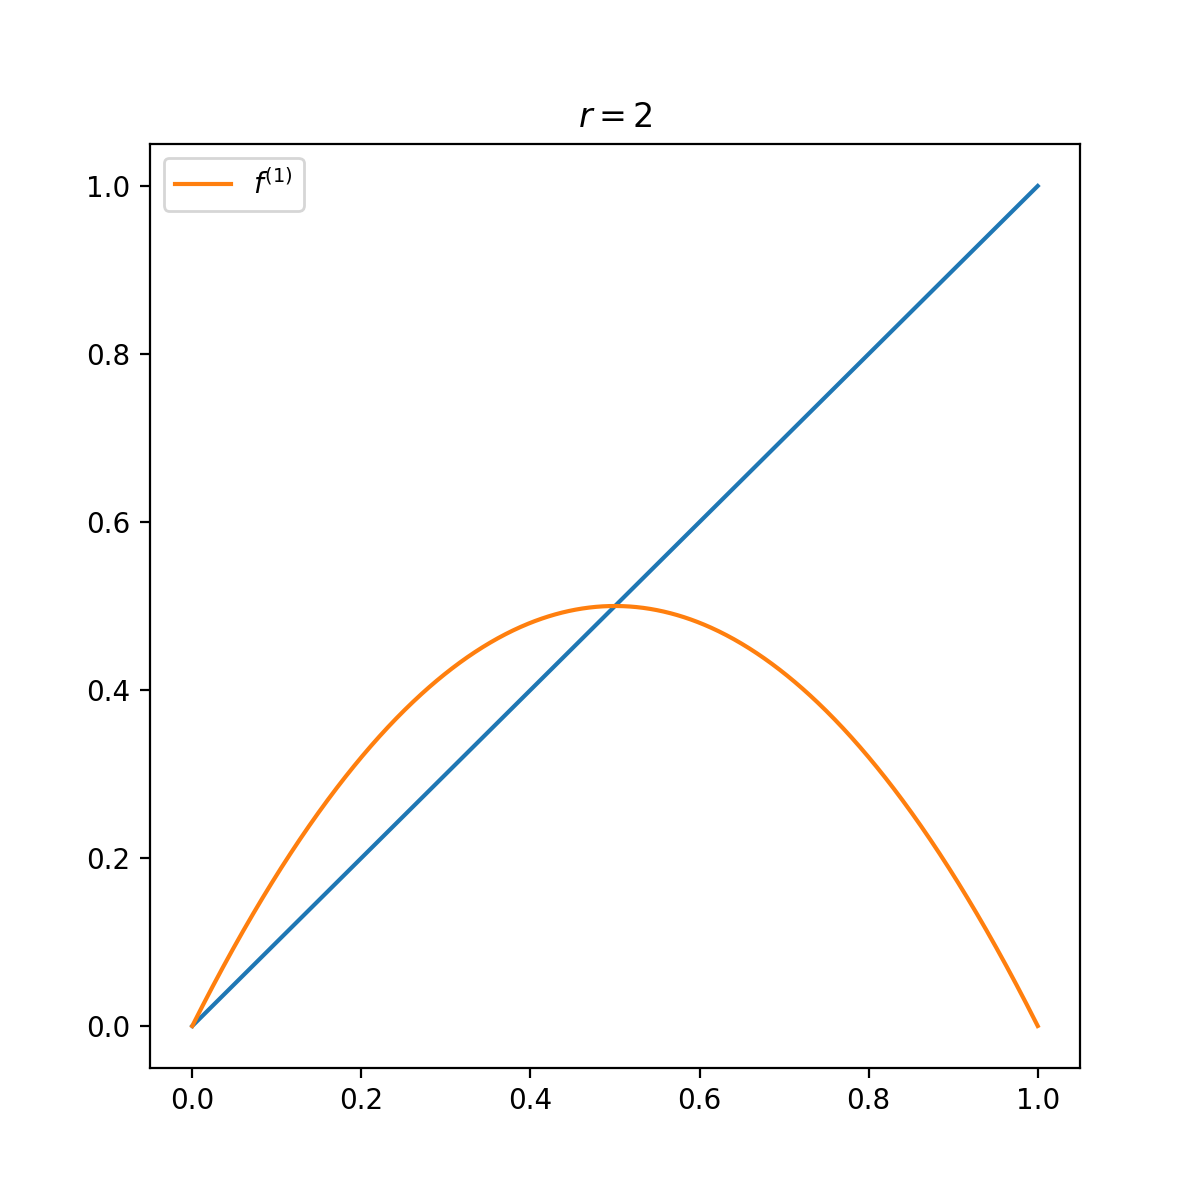

In [5]:
plot_iterates(2, [1])

For $r>3$ we can see, that the second iterate map gets two extra FP in addition to those, that are also FP of the original map. This is the points of the 2-cycle

<IPython.core.display.Javascript object>


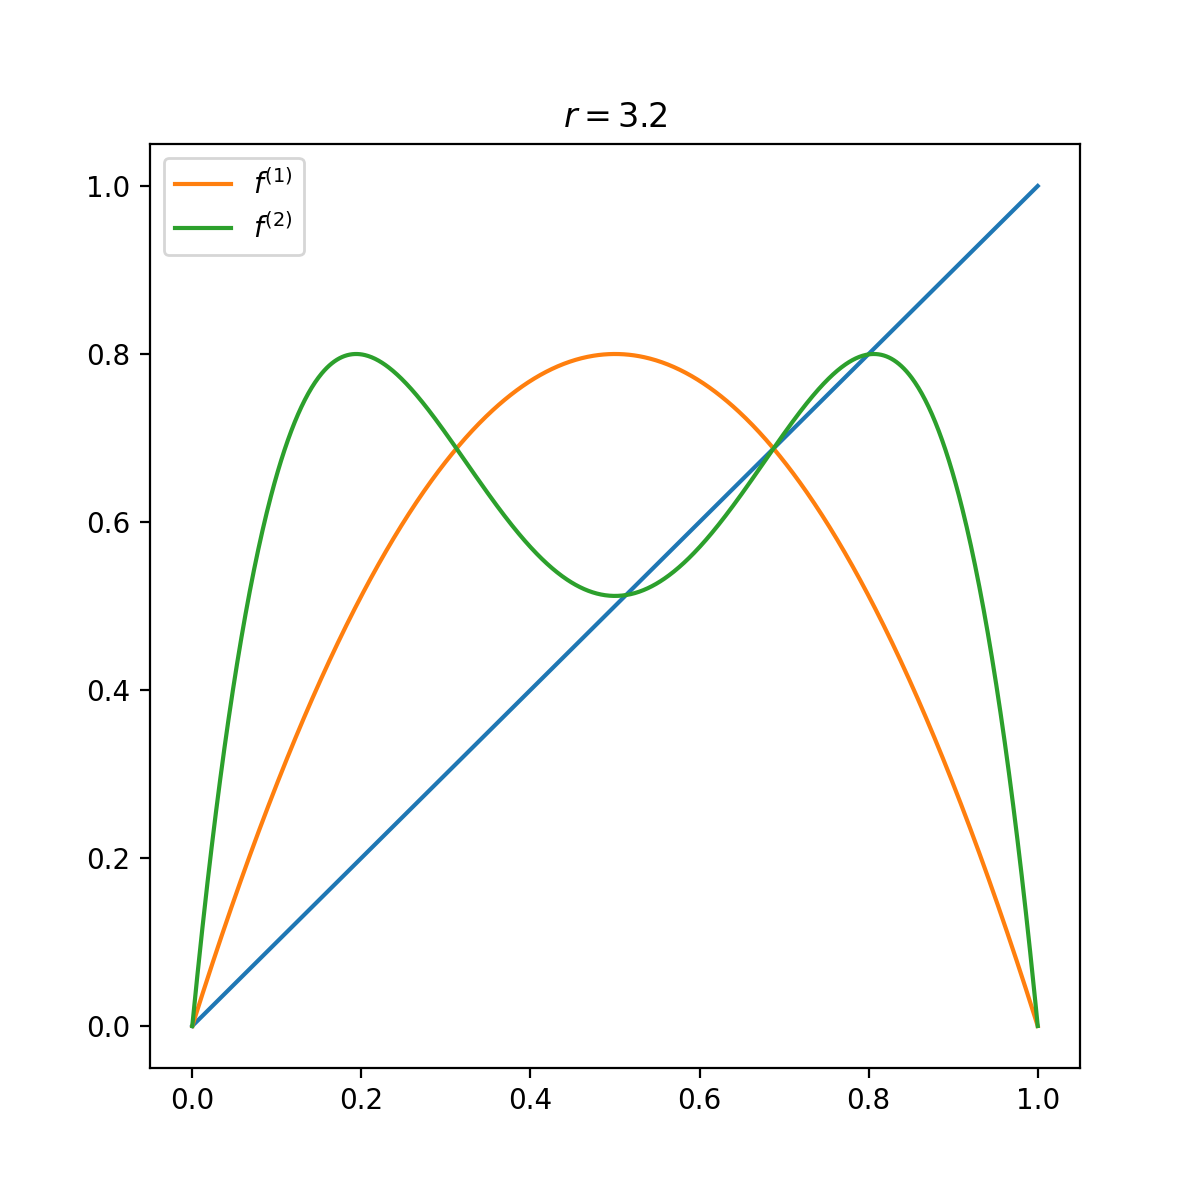

In [6]:
plot_iterates(3.2, [1,2])

This we can analyse analytically without trouble. Really, let us write the expression for the secnd iterate of the map

In [7]:
x, r=sp.symbols('x r')
def f(x,r):
    return r*x*(1-x)
f(f(x,r),r)

r**2*x*(1 - x)*(-r*x*(1 - x) + 1)

We need to solve the equation $f(x)-x=0$. It seems hard -- this is a fourth order polynomial. But, let us try to factor it

In [8]:
sp.factor(f(f(x,r),r)-x)

-x*(r*x - r + 1)*(r**2*x**2 - r**2*x - r*x + r + 1)

The first two parts is actually the expression for $f(x)-x$. That we should have expected, as far as the fixed points of the map, are also the FP of any iterated map. Check, that new zeros for the last factor appear, if $r>3$, just as we found numerically. This si the 2-cycle.

Unfortunately, for the 3rd and 4th iterate the life is not simple

In [9]:
sp.factor(f(f(f(x,r),r),r)-x)

-x*(r*x - r + 1)*(r**6*x**6 - 3*r**6*x**5 + 3*r**6*x**4 - r**6*x**3 - r**5*x**5 + 4*r**5*x**4 - 5*r**5*x**3 + 2*r**5*x**2 + r**4*x**4 - 3*r**4*x**3 + 3*r**4*x**2 - r**4*x - r**3*x**3 + 3*r**3*x**2 - 2*r**3*x + r**2*x**2 - 2*r**2*x + r**2 - r*x + r + 1)

In [10]:
sp.factor(f(f(f(f(x,r),r),r),r)-x)

-x*(r*x - r + 1)*(r**2*x**2 - r**2*x - r*x + r + 1)*(r**12*x**12 - 6*r**12*x**11 + 15*r**12*x**10 - 20*r**12*x**9 + 15*r**12*x**8 - 6*r**12*x**7 + r**12*x**6 + 3*r**11*x**10 - 15*r**11*x**9 + 30*r**11*x**8 - 30*r**11*x**7 + 15*r**11*x**6 - 3*r**11*x**5 + 3*r**10*x**8 - 12*r**10*x**7 + 18*r**10*x**6 - 12*r**10*x**5 + 3*r**10*x**4 - r**9*x**9 + 6*r**9*x**8 - 14*r**9*x**7 + 17*r**9*x**6 - 12*r**9*x**5 + 5*r**9*x**4 - r**9*x**3 - 2*r**8*x**7 + 10*r**8*x**6 - 18*r**8*x**5 + 14*r**8*x**4 - 4*r**8*x**3 - r**7*x**5 + 4*r**7*x**4 - 5*r**7*x**3 + 2*r**7*x**2 + r**6*x**6 - 4*r**6*x**5 + 6*r**6*x**4 - 4*r**6*x**3 + r**6*x**2 + 2*r**5*x**4 - 5*r**5*x**3 + 4*r**5*x**2 - r**5*x + r**4*x**2 - r**4*x - r**3*x**3 + 2*r**3*x**2 - r**3*x - r**2*x + r**2 + 1)

## Cobwebs

Let us try some graphical analysis

In [11]:
def plot_cobweb(r, x0=0.25, npoints=500, figsize=(8,3), iterate=1, xlim=(0,1), ylim=(0,1)):
    """Plot the cobweb (demonstrate it for an iterate map if ITERATE is given)"""
    fig1, (ax1, ax2) = plt.subplots(1,2, figsize=figsize) # get figure and "axes". They can be reused later.

    # Plot the map
    ax1.plot([0,1], [0,1]) # Plot the reference line
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_title("$r=%g$"%(r))
    xran = np.linspace(0, 1, num=1000)
    ax1.plot(xran, lmap_n(xran, r, iterate))

    # Initial iterations in green
    xlist1 = get_cycle(r, x0=x0, npoints=npoints)
    xlist1 = xlist1[0:-1:iterate]
    x1 = np.repeat(xlist1,2)
    x2 = np.roll(x1,-1)
    ax1.plot(x1[0:-1], x2[0:-1], color="green", linewidth=1)

    # Cycle in black
    xlist = get_cycle(r, x0=xlist1[-1], npoints=npoints)
    xlist = xlist[0:-1:iterate]
    x1 = np.repeat(xlist,2)
    x2 = np.roll(x1,-1)
    ax1.plot(x1[0:-1], x2[0:-1], color="black", linewidth=2)
    
    # Plot evolution
    ax2.plot(np.arange(len(xlist1)), xlist1, 'o-', color="green")
    ax2.plot(np.arange(len(xlist))+len(xlist1)-1, xlist, 'o-', color="black")

The iterations converge fast for smaller $r$ to the evident FP $x^*=\frac{r-1}{r}$

<IPython.core.display.Javascript object>


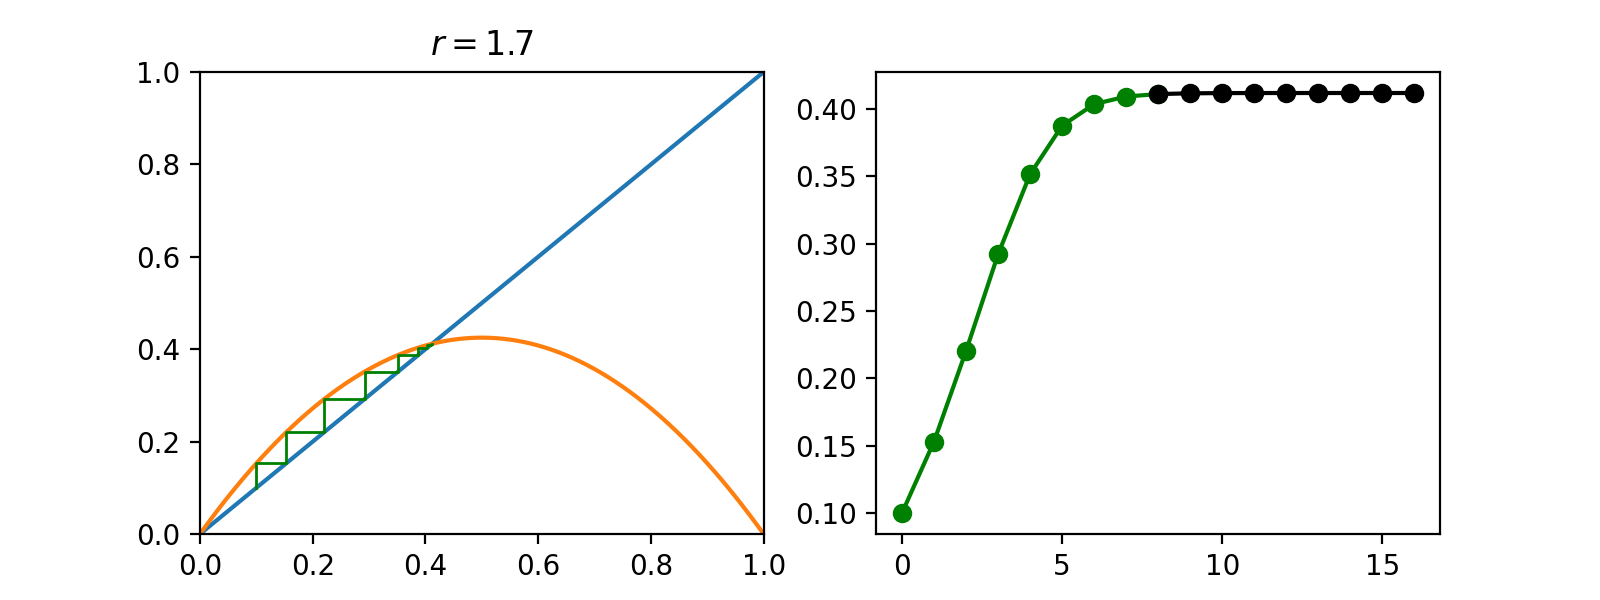

In [12]:
plot_cobweb(1.7, x0=0.1, npoints=10)

Behaviour changed for $r>2$. What happened?

<IPython.core.display.Javascript object>


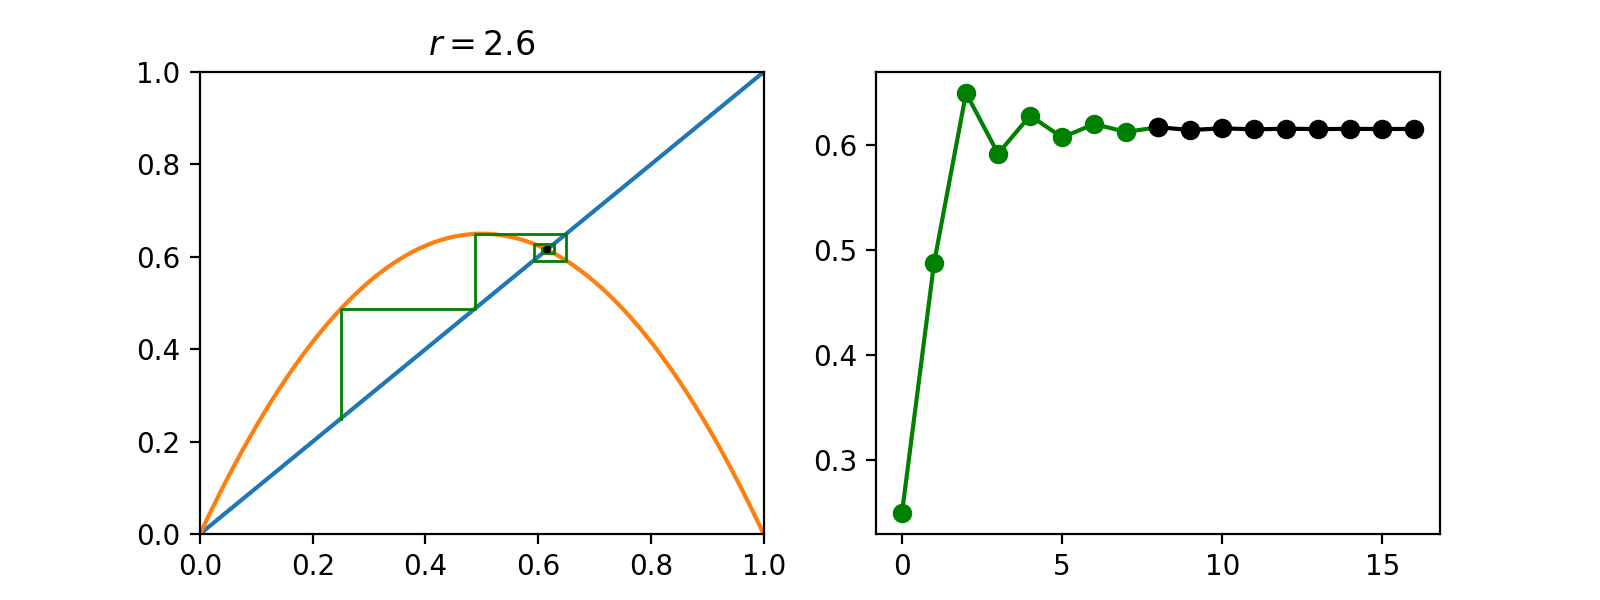

In [13]:
plot_cobweb(2.6, npoints=10)

At $r>3$, just as we found in the analytic treatment, we get a stable 2-cycle instead of the FP

<IPython.core.display.Javascript object>


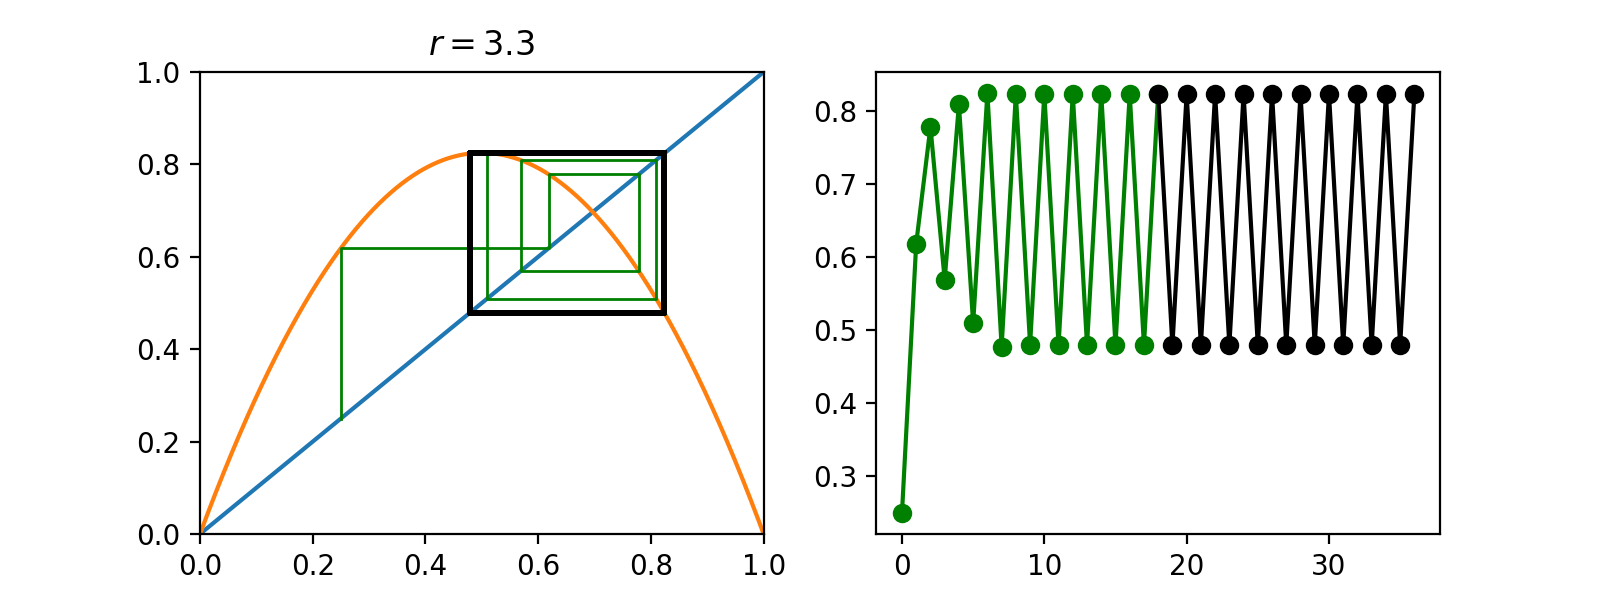

In [14]:
plot_cobweb(3.3, npoints=20)

And for $r>3.449...$ we get a 4-cycle!

<IPython.core.display.Javascript object>


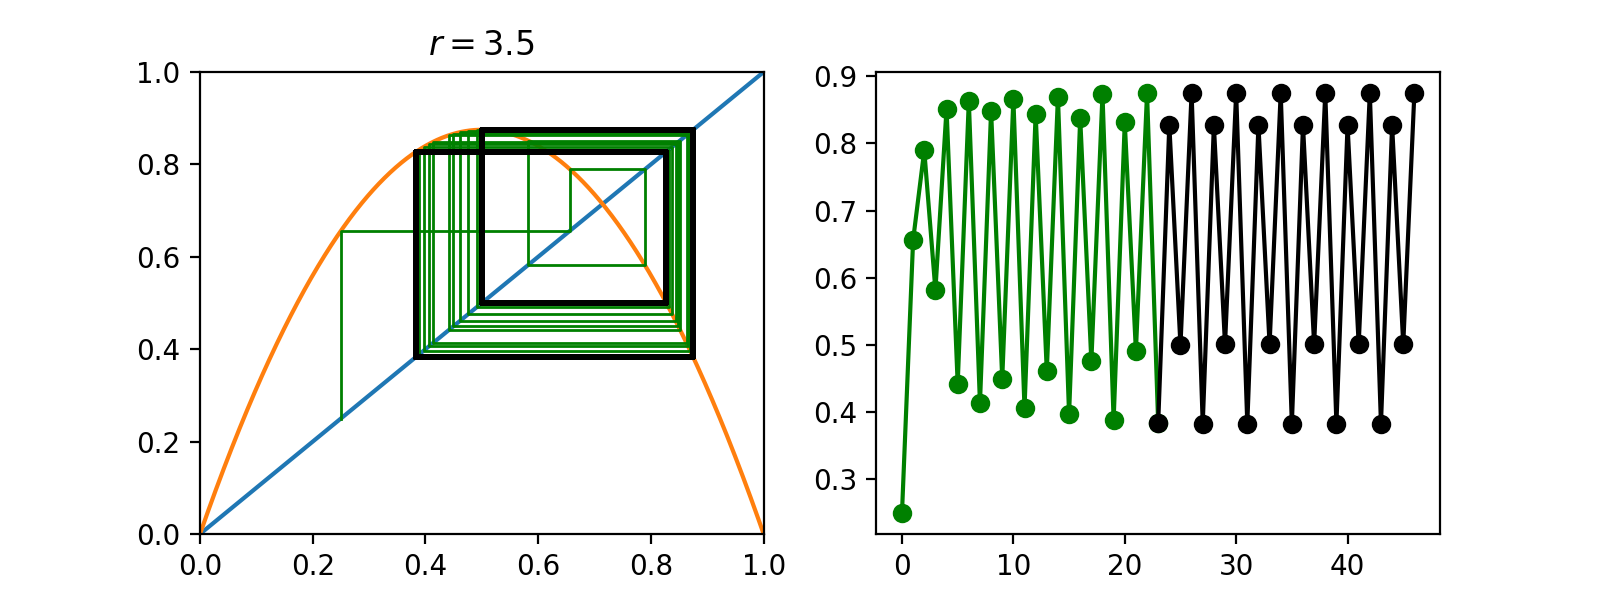

In [15]:
plot_cobweb(3.5, npoints=25)

<IPython.core.display.Javascript object>


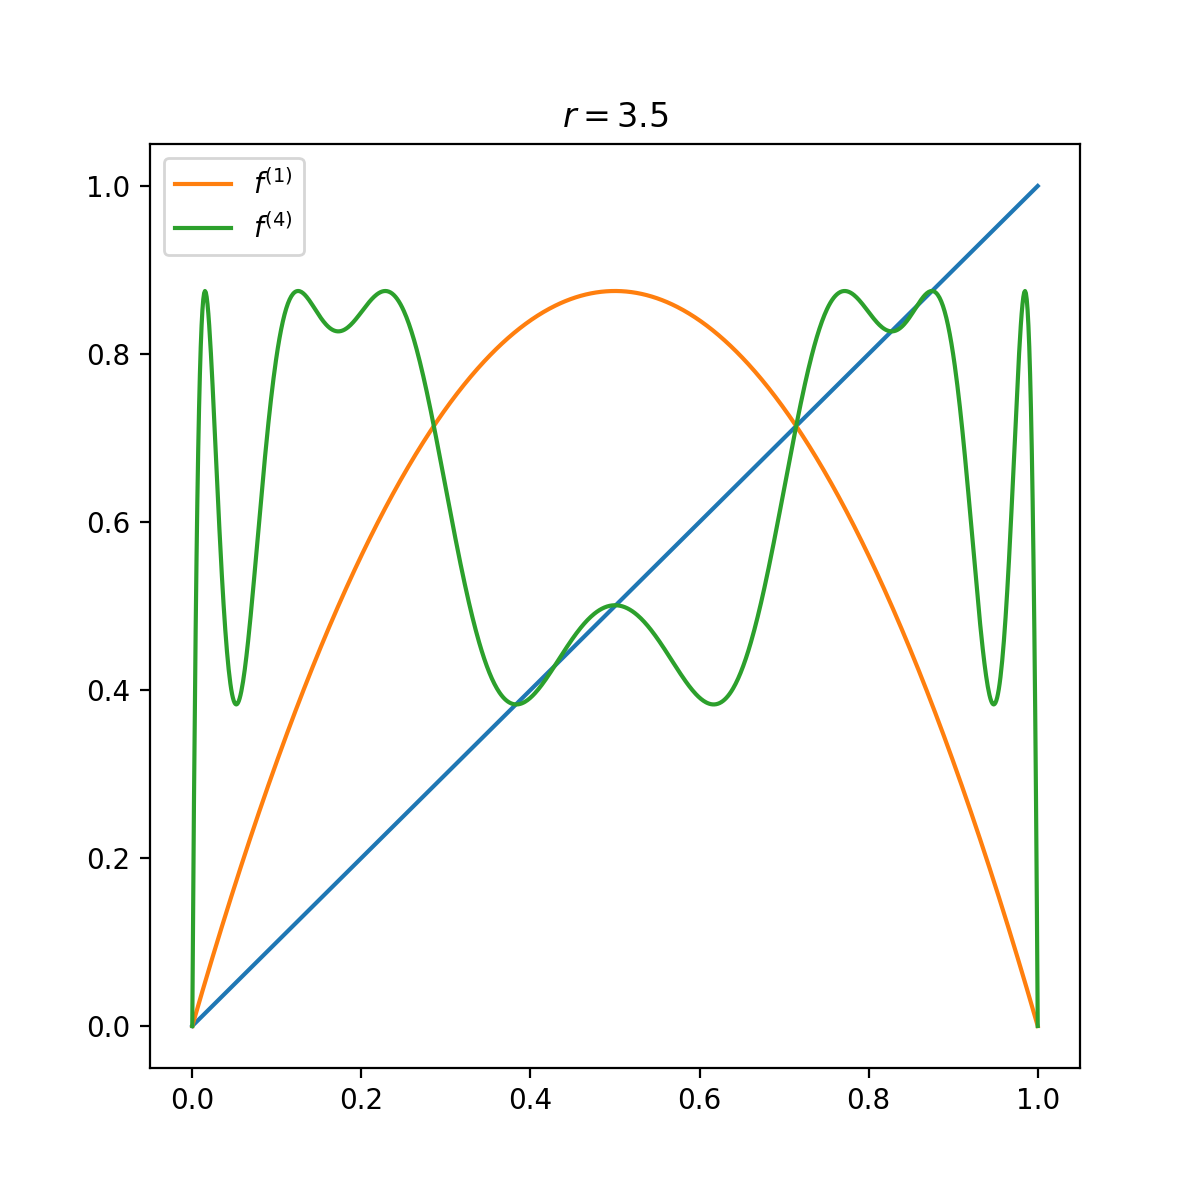

In [16]:
plot_iterates(3.5, [1,4])

And for $r>3.544...$ we get a stable 8-cycle!

<IPython.core.display.Javascript object>


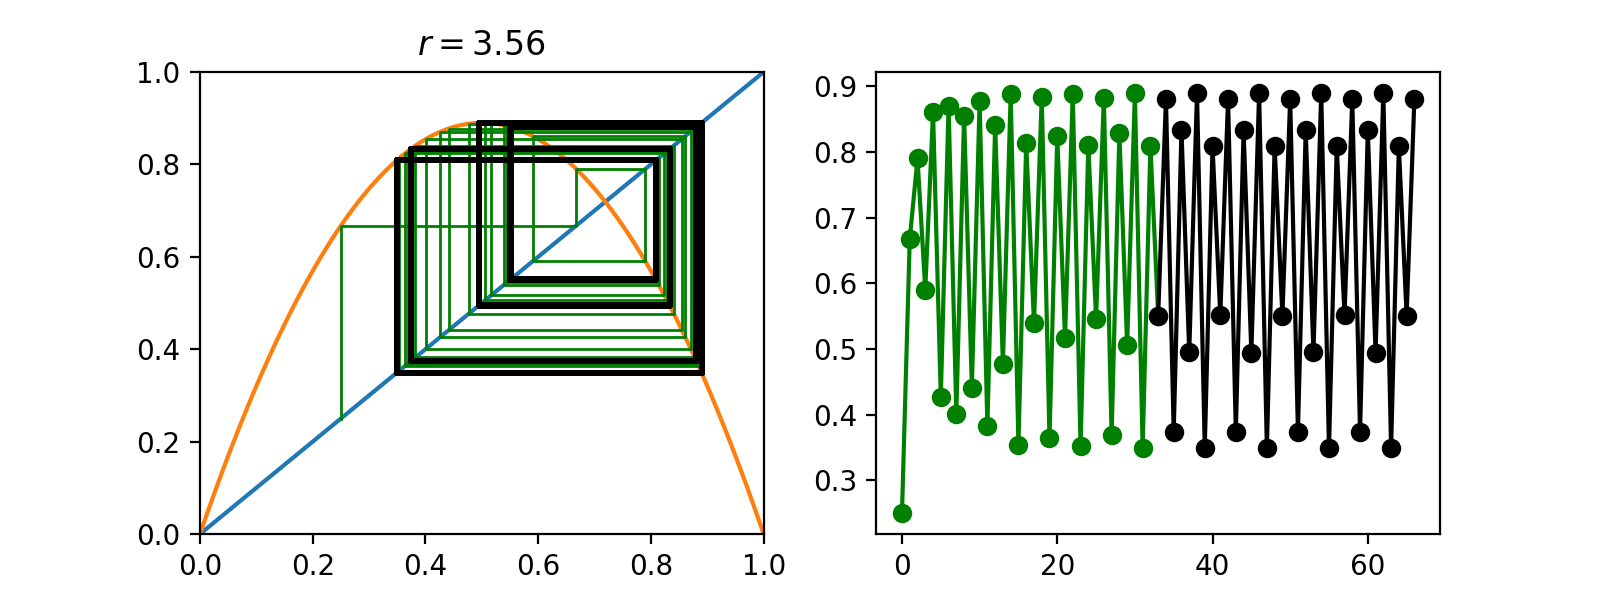

In [17]:
plot_cobweb(3.56, npoints=35)

And above $r>3.569946...$ ithe dynamics is fully chaotic!

<IPython.core.display.Javascript object>


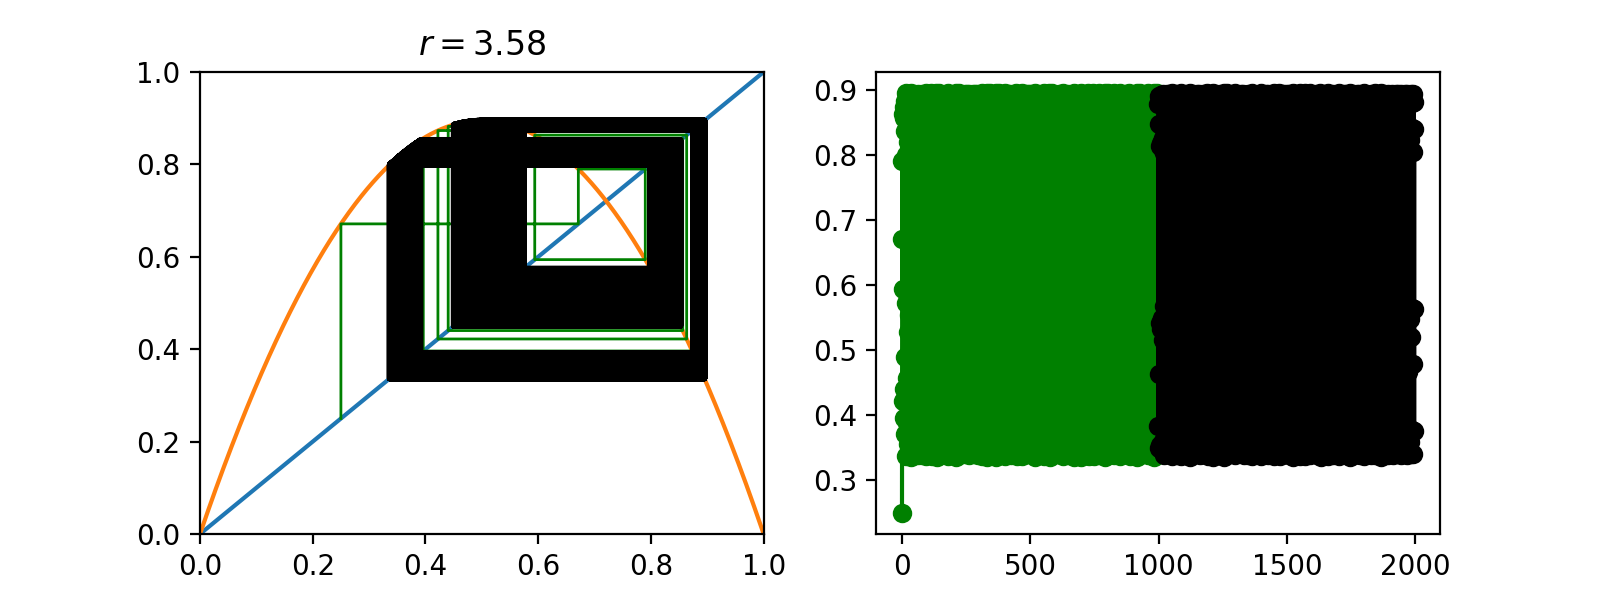

In [18]:
plot_cobweb(3.58, npoints=1000)

## The limiting points for all $r$

Let us try to see the whole picture -- plot all the stable limit cycles for all $r$.

To do this, for $r$ equally spaced between 2 and 4, let us take some random starting point $x_0$, get the sequence or many (2000) iterations, to make sure the map converged to a cycle, and then run the iterations further for some time so that we get it iterated through all the points of the stable cycle. Then, we plot all the obtained points on the plane $(r,x)$, so that each point here represents either a fixed point, or one of the points of a stable cycle.

<IPython.core.display.Javascript object>


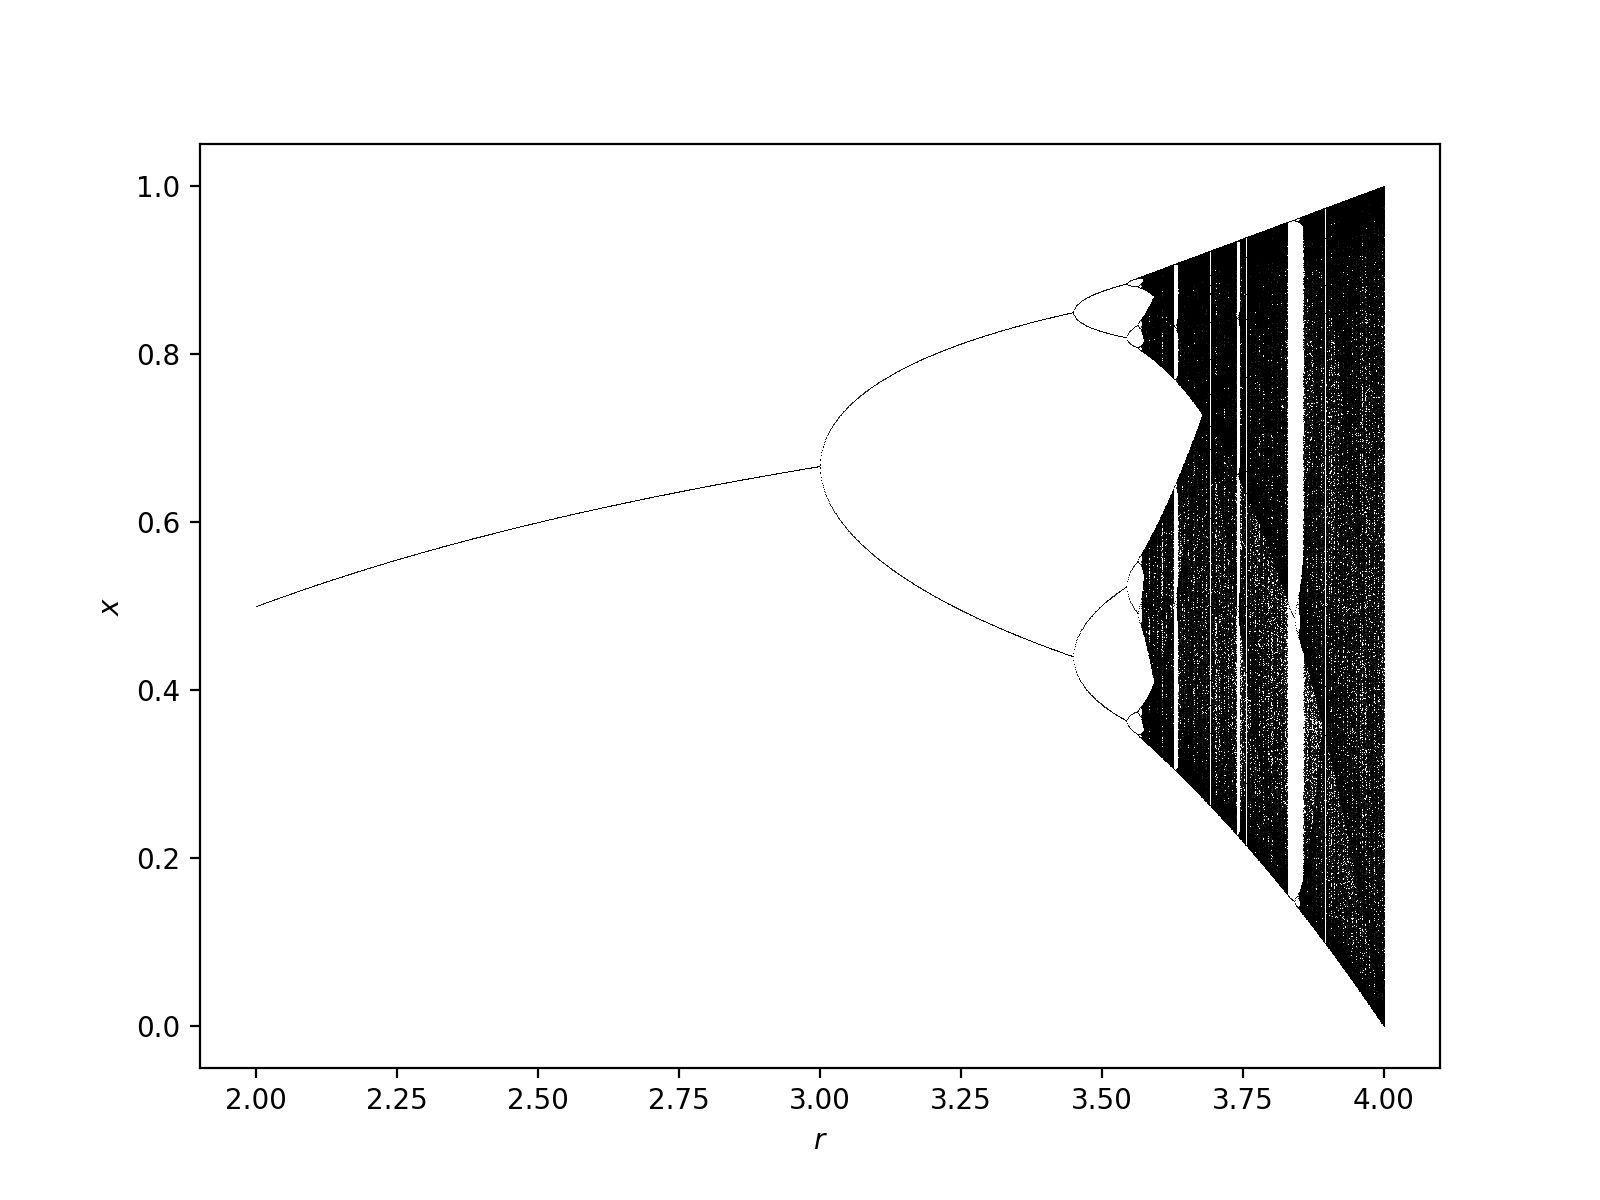

CPU times: user 2.36 s, sys: 648 ms, total: 3.01 s
Wall time: 3.02 s


In [19]:
@jit
def iterate_lmap(r, x0, n):
    """make N iterations of the Logistic map"""
    x = x0
    for i in range(n-1):
        x = lmap(x,r)
    return x

@jit
def get_logistic_map(rran, cyclepoints=2000):
    """Get all the points in (r,x) plane that belong to the stable cycles as two lists"""
    rr = np.empty(0)
    rx = np.empty(0)
    for r in rran:
        x = iterate_lmap(r, np.random.random(), cyclepoints)
        cycle = np.unique(get_cycle(r, x0=x, npoints=cyclepoints)) # Accelerate a bit by taking only unique
        rr = np.concatenate((rr, np.full_like(cycle, r))) # We add the length(cycle) times current r
        rx = np.concatenate((rx, cycle))
    return (rr, rx)

# Note, we can not do @jit here -- only numeric code can be accelerated, not plotting
def plotthemap(rran, cyclepoints=2000, figsize=(8,6)):
    fig2 = plt.figure(figsize=figsize)
    ax2 = fig2.subplots(1)
    ax2.set_xlabel("$r$")
    ax2.set_ylabel("$x$")
    rr, rx = get_logistic_map(rran, cyclepoints)
    ax2.scatter(rr, rx, lw=0, s=0.1, color="black")

rran=np.linspace(2, 4, num=2000) # You can change the range to "zoom"
#rran=np.linspace(3.82, 3.86, num=2000) # You can change the range to "zoom"
%time plotthemap(rran, cyclepoints=2000)

Wait, let us zoom in one of the regular windows, what is it?

<IPython.core.display.Javascript object>


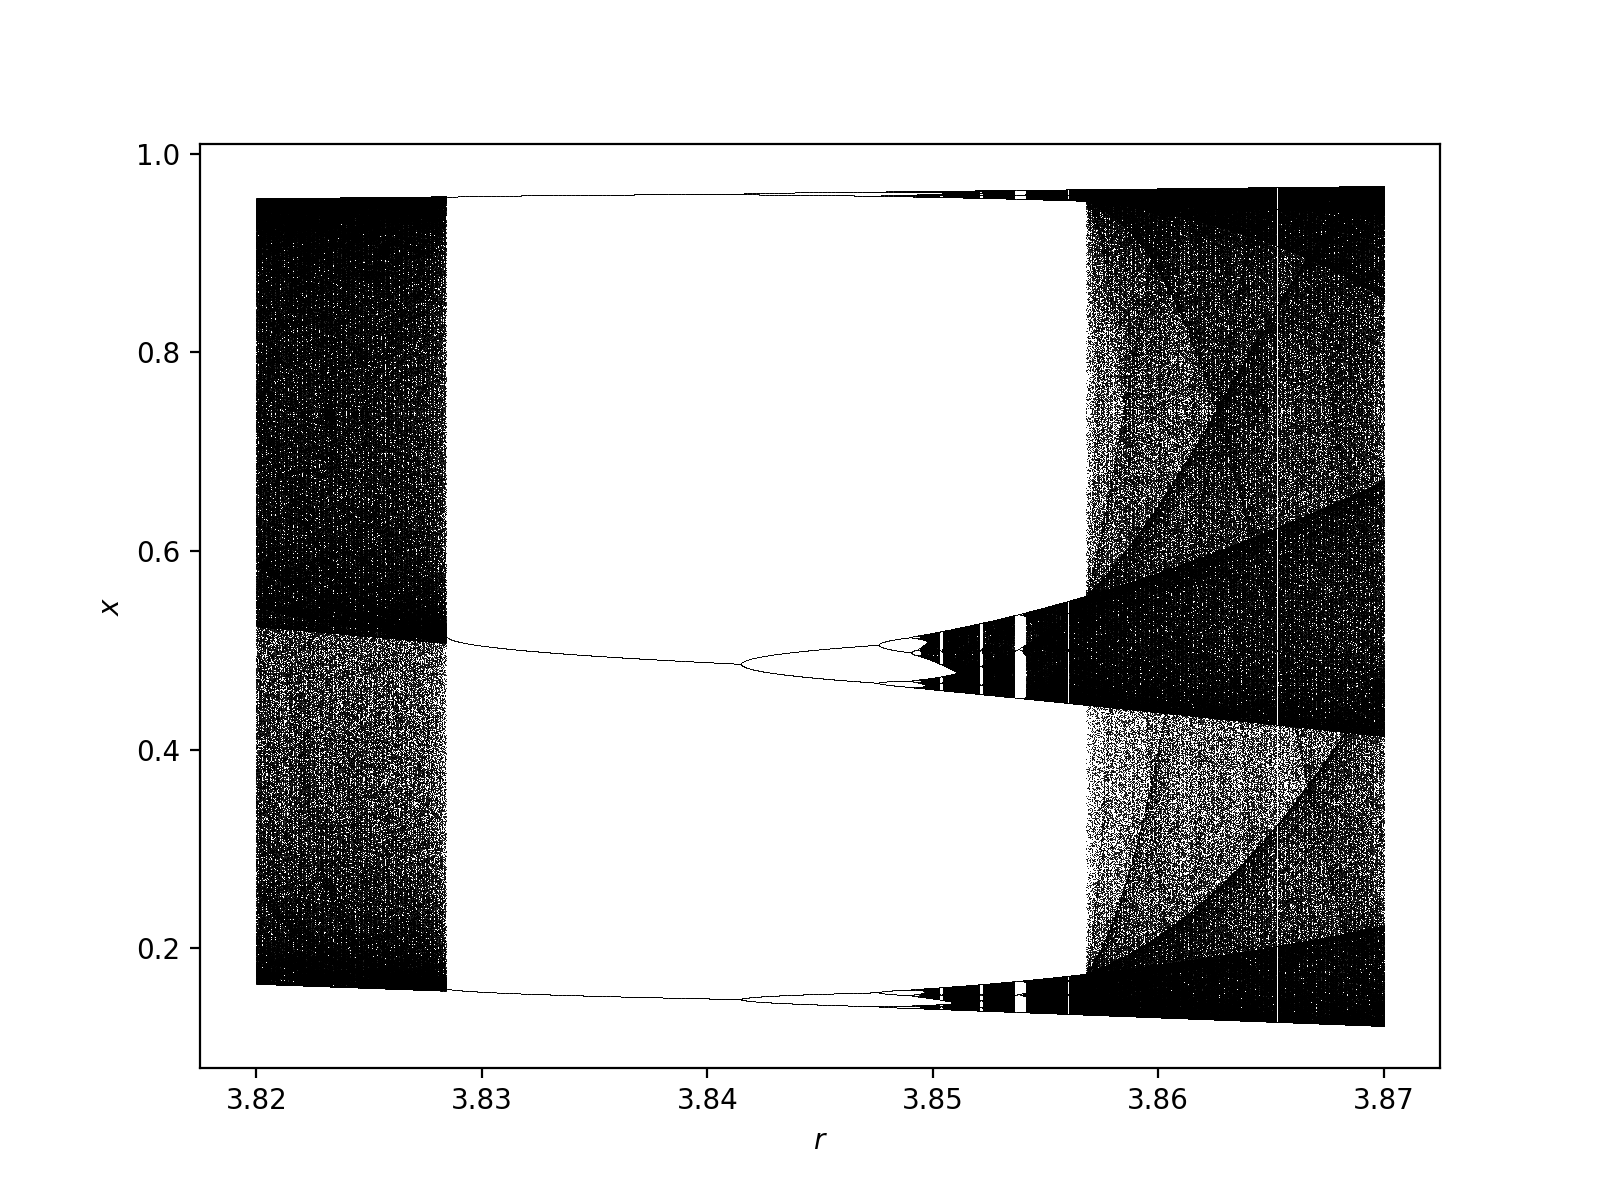

In [20]:
plotthemap(np.linspace(3.82,3.87,num=2000), cyclepoints=2000)

What an exciting picture! First, afte $r>3.8284...$ we the behaviour is again periodic. Then, we see that each line in this region gives rise at larger $r$ to a picture that closely resembles the whole plot.  The bifurcation diagram is a _fractal_.

Last, but not least, the cycle is a 3-cycle.

<IPython.core.display.Javascript object>


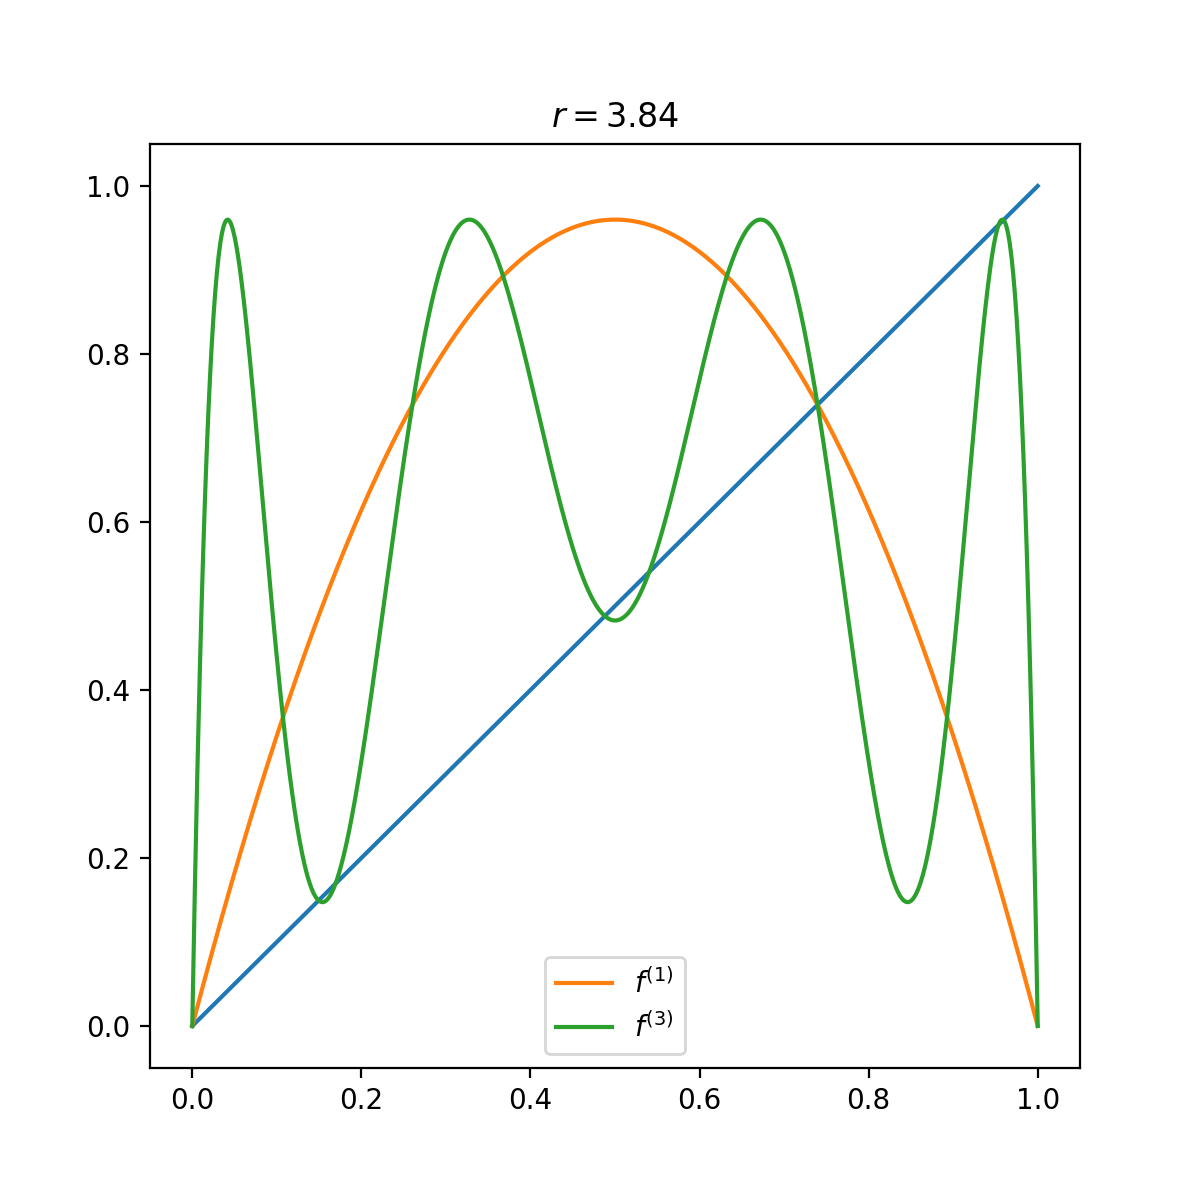

In [21]:
plot_iterates(3.84, [1,3])

We can also not a very interesting chaotic behaviour - _intermittent chaos_ for values of $r$ just before the window.  The cobweb 'lingers' for some time near the point that would give rise to the cycle.

<IPython.core.display.Javascript object>


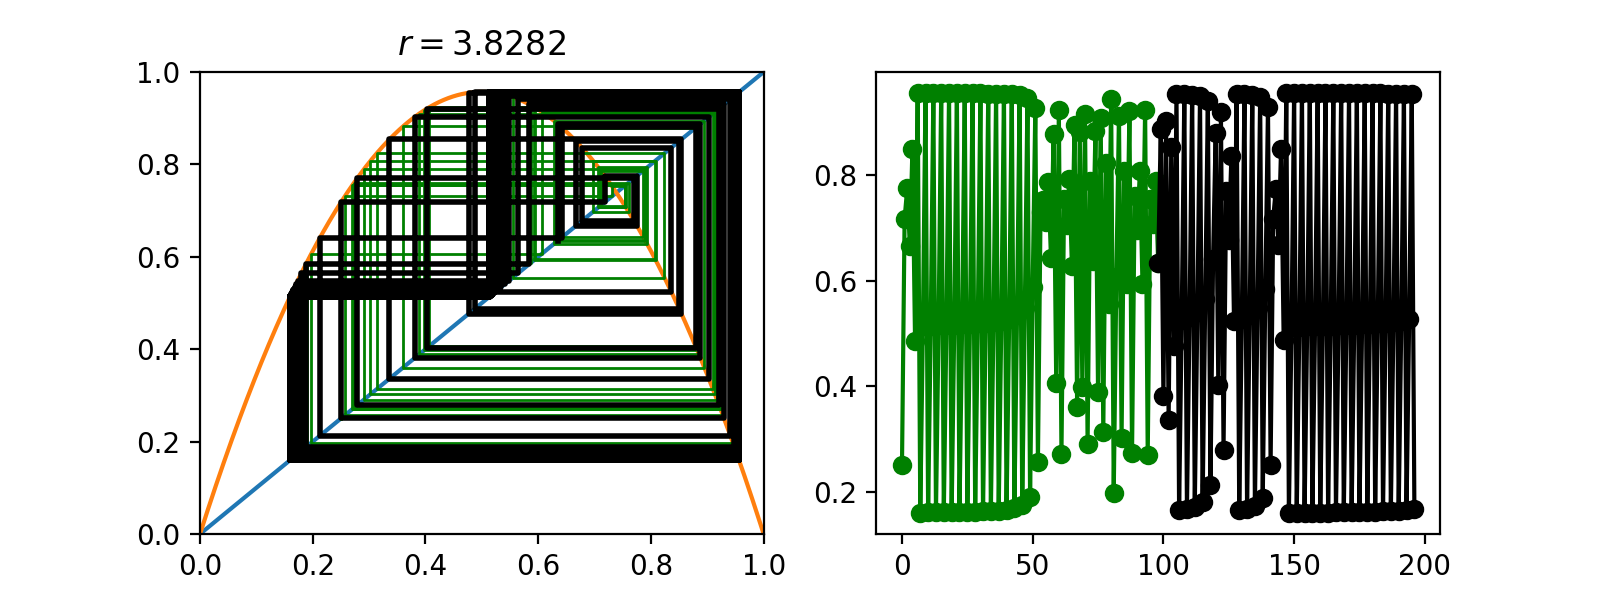

In [22]:
plot_cobweb(3.8282, npoints=100)

Zoom into the 'would be' period three point of the map to see, why the map sepnds quite some time there. (Note, the cobweb here is plotted for the 3rd iterate of the map, not for the original map!)

<IPython.core.display.Javascript object>


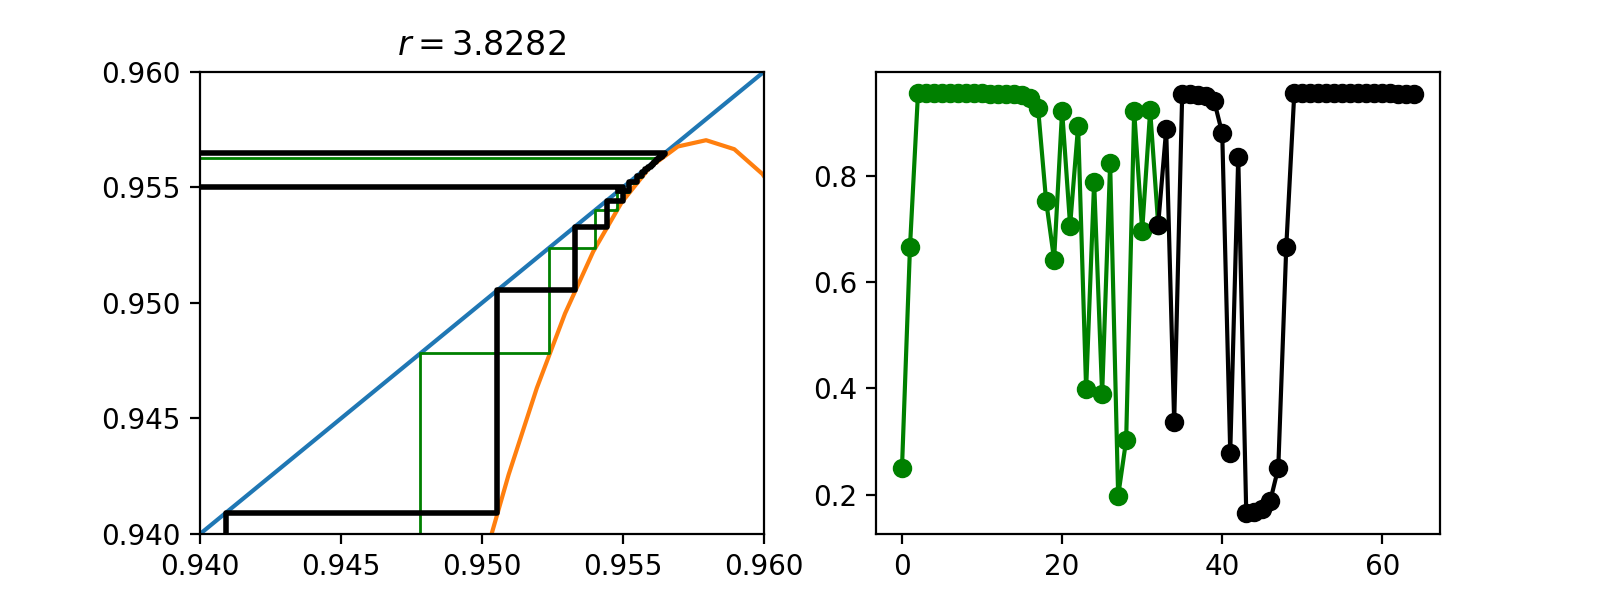

In [23]:
plot_cobweb(3.8282, npoints=100, iterate=3, xlim=(0.94,0.96), ylim=(0.94,0.96))